In [1]:
from matplotlib import image
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from itertools import chain

In [4]:
import sys
sys.path.insert(0, os.getenv('lib_path'))

In [5]:
import breast_segment

In [6]:
filenames_dict = {}
classes = ['1','2','3','4']
subsets = ['train','valid','test']
folder = 'vindr_four_classes'

In [8]:
filenames_paths = {}
filenames_dict = {}
for density_class in classes:
    filenames_dict[density_class] = []
    filenames_paths[density_class] = {}
    files = os.listdir(
        os.path.join(os.getenv('data_path'),'baza_student_raw',folder,density_class)
    )
    # files = [x for x in files if not x.startswith('augmented')]
    files_filled = [x.zfill(15) for x in files if x.endswith('.png')]
    filenames_dict[density_class] +=files_filled
    for file in files:
        filenames_paths[file] = os.path.join(os.getenv('data_path'),'baza_student_raw',folder,density_class, file)
for key, value in filenames_dict.items():
    value.sort()

In [12]:
exceptions = []

In [13]:
patients_ids_class = {}
patient_id = 0
exceptions_iter = 0
for density_class, filenames in filenames_dict.items():
    file_ids = 0
    while file_ids<(filenames.__len__()):
        try:
            four_in_a_row = (abs(int(filenames[file_ids][:5]) - int(filenames[file_ids+3][:5]))==3)
        except:
            four_in_a_row = False
        if filenames[file_ids] in exceptions:
            patients_ids_class[filenames[file_ids]] = {'patient_id':1000000+exceptions_iter, 'density':density_class}

            exceptions_iter +=1
            file_ids+=1
            
        elif four_in_a_row:
            for i in range(4):
                filename = filenames[file_ids]
                patients_ids_class[filenames[file_ids]] = {'patient_id':patient_id, 'density':density_class}
                
                file_ids+=1
        else:
            for i in range(1):
                filename = filenames[file_ids]
                patients_ids_class[filenames[file_ids]] = {'patient_id':patient_id, 'density':density_class}
                
                file_ids+=1

        patient_id +=1

In [14]:
patients_ids_class_df = pd.DataFrame.from_dict(patients_ids_class).T

In [15]:
patients_ids_class_df.sort_index()

,patient_id,density
00000_vindr.png,535,3
00001_vindr.png,535,3
00002_vindr.png,535,3
00003_vindr.png,535,3
00004_vindr.png,536,3
...,...,...
19995_vindr.png,4401,3
19996_vindr.png,4402,3
19997_vindr.png,4402,3
19998_vindr.png,4402,3


In [16]:
patients_ids_class_df.shape

(20000, 2)

In [17]:
counter = patients_ids_class_df.groupby('patient_id').count()

In [20]:
counter.loc[counter.density<4]

,density
patient_id,
17,1
18,1
23,1
24,1
65,1
...,...
5031,1
5068,1
5069,1


In [18]:
patients_ids_class_df.loc[np.isin(patients_ids_class_df.patient_id,counter.loc[counter.density<4].index)].sort_index()[:20]

,patient_id,density
00936_vindr.png,716,3
00937_vindr.png,717,3
00938_vindr.png,4437,4
00939_vindr.png,4438,4
01704_vindr.png,863,3
01705_vindr.png,864,3
01706_vindr.png,65,2
01707_vindr.png,66,2
02372_vindr.png,996,3
02373_vindr.png,997,3


In [21]:
patients_ids_class_df.loc[np.isin(patients_ids_class_df.patient_id,counter.loc[counter.density<4].index)].sort_index().index

Index(['00936_vindr.png', '00937_vindr.png', '00938_vindr.png',
       '00939_vindr.png', '01704_vindr.png', '01705_vindr.png',
       '01706_vindr.png', '01707_vindr.png', '02372_vindr.png',
       '02373_vindr.png',
       ...
       '19118_vindr.png', '19119_vindr.png', '19284_vindr.png',
       '19285_vindr.png', '19310_vindr.png', '19311_vindr.png',
       '19496_vindr.png', '19497_vindr.png', '19498_vindr.png',
       '19499_vindr.png'],
      dtype='object', length=128)

In [22]:
mapper =  patients_ids_class_df.groupby('patient_id')['density'].first().reset_index()

In [23]:
mapper.head()

,patient_id,density
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [24]:
train_ids, test_ids_tmp = train_test_split(mapper.patient_id, test_size=0.4, random_state=42, stratify=mapper.density)

In [25]:
val_ids, test_ids = train_test_split(test_ids_tmp, test_size=0.5, random_state=42, stratify=mapper.loc[np.isin(mapper.patient_id,test_ids_tmp)].density)

In [26]:
mapper.loc[np.isin(mapper.patient_id,train_ids)].groupby('density').count()/len(train_ids)

,patient_id
density,
1,0.005561
2,0.099444
3,0.758914
4,0.136081


In [27]:
mapper.loc[np.isin(mapper.patient_id,val_ids)].groupby('density').count()/len(val_ids)

,patient_id
density,
1,0.003925
2,0.104024
3,0.766438
4,0.125613


In [28]:
mapper.loc[np.isin(mapper.patient_id,test_ids)].groupby('density').count()/len(test_ids)

,patient_id
density,
1,0.006863
2,0.095098
3,0.751961
4,0.146078


In [29]:
patients_ids_class_df.loc[np.isin(patients_ids_class_df.patient_id,test_ids)&(patients_ids_class_df.density == '1')]

,patient_id,density
02820_vindr.png,6,1
02821_vindr.png,6,1
02822_vindr.png,6,1
02823_vindr.png,6,1
02856_vindr.png,7,1
02857_vindr.png,7,1
02858_vindr.png,7,1
02859_vindr.png,7,1
07692_vindr.png,14,1
07693_vindr.png,14,1


In [30]:
subsets = {'train':train_ids,'valid':val_ids, 'test':test_ids}
classes = ['1','2','3','4']

In [31]:
os.mkdir(os.path.join(os.getenv('data_path'),'baza_student_raw','vindr_four_classes_split'))

In [53]:
test_black = image.imread('1481_vindr.png')

In [38]:
test_black = image.imread('13803_vindr.png')

In [117]:
test_white = image.imread('16122_vindr.png')

In [40]:
test_black.mean()

0.015928091

In [120]:
test_white.mean()

0.51786643

In [121]:
img = abs(test_white-test_white.min())/(test_white.max()-test_white.min())

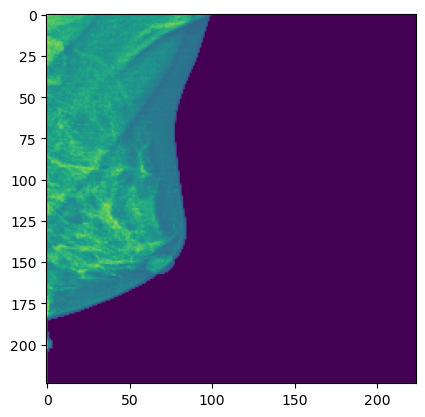

In [119]:
plt.imshow(abs(test_white-1))

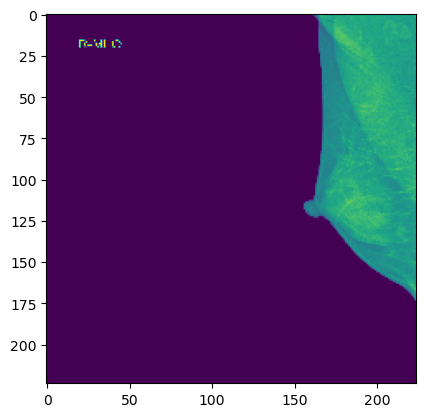

In [44]:
plt.imshow(abs(test_black-test_black.min())/(test_black.max()-test_black.min()))

In [47]:
test_black.max()

0.15686275

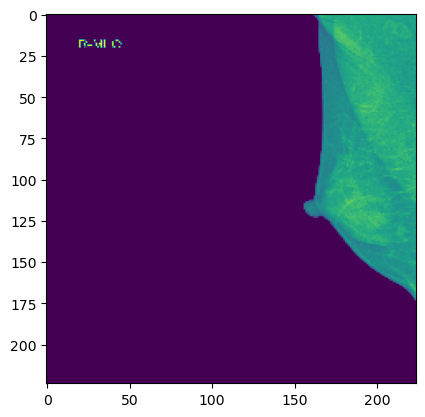

In [45]:
plt.imshow(test_black)

In [127]:

img = image.imread('19608_vindr.png')

In [130]:
img.mean()

0.3167979

In [129]:
img = abs(img-img.min())/(img.max()-img.min())

In [124]:
if img.mean()>0.15:
        img = abs(img-1)

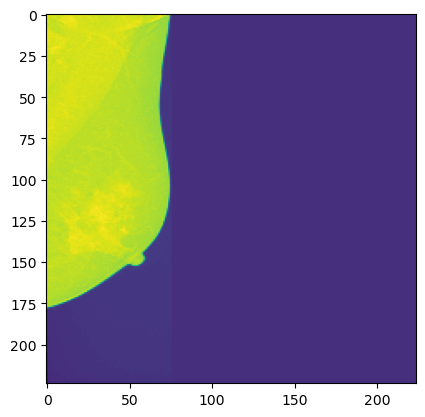

In [131]:
plt.imshow(img)

In [115]:
img.mean()

0.07159032

In [77]:
img*255

array([[ 99.99999,  99.99999,  99.99999, ..., 181.99998, 189.99998,
        200.     ],
       [ 99.99999,  99.99999,  99.99999, ..., 198.     , 201.     ,
        200.     ],
       [ 99.99999,  99.99999,  99.99999, ..., 199.     , 215.     ,
        215.     ],
       ...,
       [ 99.99999,  99.99999,  99.99999, ..., 181.     , 198.     ,
        199.     ],
       [ 99.99999,  99.99999,  99.99999, ..., 181.     , 187.     ,
        204.     ],
       [ 99.99999,  99.99999,  99.99999, ..., 175.99998, 179.     ,
        202.     ]], dtype=float32)

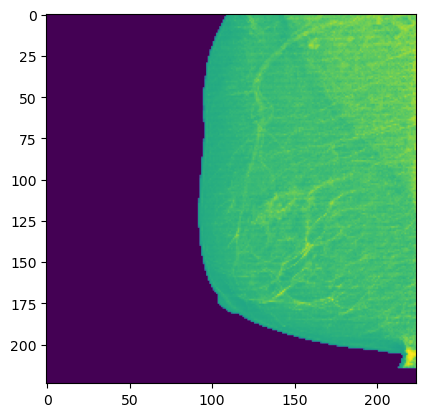

In [81]:
plt.imshow(breast_segment.segment_breast(img,100))

In [132]:
for subset_name, subset_ids in subsets.items():
    upper_root = os.path.join(os.getenv('data_path'),'baza_student_raw','vindr_four_classes_split', subset_name)
    if not os.path.exists(upper_root):
            os.mkdir(upper_root)
    for density_class in classes:
        root_old = os.path.join(os.getenv('data_path'),'baza_student_raw','vindr_four_classes_split', density_class)
        root_new = os.path.join(os.getenv('data_path'),'baza_student_raw','vindr_four_classes_split', subset_name, density_class)
        if not os.path.exists(root_new):
            os.mkdir(root_new)
        filenames = patients_ids_class_df.loc[np.isin(patients_ids_class_df.patient_id,subset_ids)&(patients_ids_class_df.density==density_class)].index.values
        for file in filenames:
            origin_filename = file[:4].lstrip('0')+file[4:]
            img = image.imread(filenames_paths[origin_filename])
            img = abs(img-img.min())/(img.max()-img.min())
            if img.mean()>0.4:
                 img = abs(img-1)
            segmented = breast_segment.segment_breast(img,30)
            pil_version = Image.fromarray(np.uint8(segmented*255), 'L')
            pil_version.save(os.path.join(root_new,origin_filename))

In [ ]:
i=0
for root, _ , files in os.walk(os.path.join(os.getenv('data_path'),'baza_student_raw','ddsm_four_classes')):
    for file in files:
            if file.endswith(".png"):
                img = image.imread(os.path.join(root,file))
                print(file)
                segmented = breast_segment.segment_breast(img,30)
                f, axarr = plt.subplots(1,2)
                axarr[0].imshow(img)
                axarr[1].imshow(segmented, vmax = 1)
                plt.show()
                i+=1